In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
train_file, test_file = 'Train.csv', 'Test.csv'

In [3]:
df, tdf = pd.read_csv(train_file), pd.read_csv(test_file)

In [4]:
df = df.drop(columns=['ID'], inplace=False)[df['stock'] == 1]
tdf = tdf[tdf['stock'] == 1]

In [5]:
df

,stock,Date,Open,High,Low,Close,holiday,unpredictability_score
713,1,2017-01-03,38.4097,38.2343,38.6799,38.4540,1,0
714,1,2017-01-04,38.5551,38.3790,38.8260,38.5994,0,0
715,1,2017-01-05,38.5551,38.3790,38.8260,38.5994,0,0
716,1,2017-01-06,38.5551,38.3790,38.8260,38.5994,0,0
717,1,2017-01-09,38.5551,38.3790,38.8260,38.5994,0,0
...,...,...,...,...,...,...,...,...
1421,1,2019-10-25,45.8535,45.6797,46.1308,45.9002,0,0
1422,1,2019-10-28,45.8976,45.7155,46.1353,45.9425,0,0
1423,1,2019-10-29,45.9066,45.7316,46.1443,45.9515,0,0
1424,1,2019-10-30,45.8697,45.6609,46.0539,45.8526,0,0


In [6]:
# max_timeshift and min_shift are hyperparams here
df_rolled = roll_time_series(df, column_id='stock', column_sort='Date', max_timeshift=20) 

Rolling: 100%|██████████| 20/20 [00:01<00:00, 17.65it/s]


In [7]:
df_rolled

,stock,Date,Open,High,Low,Close,holiday,unpredictability_score,id
0,1,2017-01-03,38.4097,38.2343,38.6799,38.4540,1,0,"(1, 2017-01-03)"
1,1,2017-01-03,38.4097,38.2343,38.6799,38.4540,1,0,"(1, 2017-01-04)"
2,1,2017-01-04,38.5551,38.3790,38.8260,38.5994,0,0,"(1, 2017-01-04)"
3,1,2017-01-03,38.4097,38.2343,38.6799,38.4540,1,0,"(1, 2017-01-05)"
4,1,2017-01-04,38.5551,38.3790,38.8260,38.5994,0,0,"(1, 2017-01-05)"
...,...,...,...,...,...,...,...,...,...
14758,1,2019-10-25,45.8535,45.6797,46.1308,45.9002,0,0,"(1, 2019-10-31)"
14759,1,2019-10-28,45.8976,45.7155,46.1353,45.9425,0,0,"(1, 2019-10-31)"
14760,1,2019-10-29,45.9066,45.7316,46.1443,45.9515,0,0,"(1, 2019-10-31)"
14761,1,2019-10-30,45.8697,45.6609,46.0539,45.8526,0,0,"(1, 2019-10-31)"


In [8]:
len(df), df_rolled.id.nunique()

(713, 713)

In [9]:
df_rolled.groupby("id").size().agg([np.min, np.max])


amin     1
amax    21
dtype: int64

In [10]:
X = extract_features(df_rolled.drop(columns=["stock", "unpredictability_score"], axis=1), 
                     column_id="id", column_sort="Date", show_warnings=False, n_jobs=7, impute_function=impute)

Feature Extraction: 100%|██████████| 35/35 [00:36<00:00,  1.03s/it]


In [11]:
X

High__variance_larger_than_standard_deviation  \
1 2017-01-03                                            0.0   
  2017-01-04                                            0.0   
  2017-01-05                                            0.0   
  2017-01-06                                            0.0   
  2017-01-09                                            0.0   
...                                                     ...   
  2019-10-25                                            0.0   
  2019-10-28                                            0.0   
  2019-10-29                                            0.0   
  2019-10-30                                            0.0   
  2019-10-31                                            0.0   

              High__has_duplicate_max  High__has_duplicate_min  \
1 2017-01-03                      0.0                      0.0   
  2017-01-04                      0.0                      0.0   
  2017-01-05                      1.0                      0.0   
  2017-01-06                      1.0                      0.0   
  2017-01-09                      1.0                      0.0   
...                               ...                      ...   
  2019-10-25                      0.0                      0.0   
  2019-10-28                      0.0                      0.0   
  2019-10-29                      0.0                      0.0   
  2019-10-30                      0.0                      0.0   
  2019-10-31                      0.0                      0.0   

              High__has_duplicate  High__sum_values  High__abs_energy  \
1 2017-01-03                  0.0           38.2343       1461.861696   
  2017-01-04                  0.0           76.6133       2934.809337   
  2017-01-05                  1.0          114.9923       4407.756978   
  2017-01-06                  1.0          153.3713       5880.704619   
  2017-01-09                  1.0          191.7503       7353.652260   
...                           ...               ...               ...   
  2019-10-25                  0.0          952.9785      43246.784303   
  2019-10-28                  0.0          953.2915      43275.304237   
  2019-10-29                  0.0          953.5315      43297.197805   
  2019-10-30                  0.0          953.8167      43323.161443   
  2019-10-31                  0.0          954.1482      43353.213675   

              High__mean_abs_change  High__mean_change  \
1 2017-01-03               0.079062           0.010875   
  2017-01-04               0.144700           0.144700   
  2017-01-05               0.072350           0.072350   
  2017-01-06               0.048233           0.048233   
  2017-01-09               0.036175           0.036175   
...                             ...                ...   
  2019-10-25               0.074510           0.013860   
  2019-10-28               0.071845           0.011195   
  2019-10-29               0.066855           0.017795   
  2019-10-30               0.059700           0.024950   
  2019-10-31               0.064510           0.020140   

              High__mean_second_derivative_central  High__median  ...  \
1 2017-01-03                              0.000000      38.23430  ...   
  2017-01-04                              0.000000      38.30665  ...   
  2017-01-05                             -0.072350      38.37900  ...   
  2017-01-06                             -0.036175      38.37900  ...   
  2017-01-09                             -0.024117      38.37900  ...   
...                                            ...           ...  ...   
  2019-10-25                             -0.000695      45.40250  ...   
  2019-10-28                              0.003992      45.47020  ...   
  2019-10-29                              0.006050      45.47020  ...   
  2019-10-30                              0.000016      45.47200  ...   
  2019-10-31                             -0.006987      45.48270  ...   

             

In [12]:
X.shape

(713, 3895)

In [13]:
X.columns

Index(['High__variance_larger_than_standard_deviation',
       'High__has_duplicate_max', 'High__has_duplicate_min',
       'High__has_duplicate', 'High__sum_values', 'High__abs_energy',
       'High__mean_abs_change', 'High__mean_change',
       'High__mean_second_derivative_central', 'High__median',
       ...
       'Open__fourier_entropy__bins_2', 'Open__fourier_entropy__bins_3',
       'Open__fourier_entropy__bins_5', 'Open__fourier_entropy__bins_10',
       'Open__fourier_entropy__bins_100',
       'Open__permutation_entropy__dimension_3__tau_1',
       'Open__permutation_entropy__dimension_4__tau_1',
       'Open__permutation_entropy__dimension_5__tau_1',
       'Open__permutation_entropy__dimension_6__tau_1',
       'Open__permutation_entropy__dimension_7__tau_1'],
      dtype='object', length=3895)

In [14]:
X.index

MultiIndex([(1, '2017-01-03'),
            (1, '2017-01-04'),
            (1, '2017-01-05'),
            (1, '2017-01-06'),
            (1, '2017-01-09'),
            (1, '2017-01-10'),
            (1, '2017-01-11'),
            (1, '2017-01-12'),
            (1, '2017-01-13'),
            (1, '2017-01-17'),
            ...
            (1, '2019-10-18'),
            (1, '2019-10-21'),
            (1, '2019-10-22'),
            (1, '2019-10-23'),
            (1, '2019-10-24'),
            (1, '2019-10-25'),
            (1, '2019-10-28'),
            (1, '2019-10-29'),
            (1, '2019-10-30'),
            (1, '2019-10-31')],
           length=713)

In [15]:

X = X.set_index(X.index.map(lambda x: x[1]), drop=True)
X.index.name = "last_date"
X

,High__variance_larger_than_standard_deviation,High__has_duplicate_max,High__has_duplicate_min,High__has_duplicate,High__sum_values,High__abs_energy,High__mean_abs_change,High__mean_change,High__mean_second_derivative_central,High__median,...,Open__fourier_entropy__bins_2,Open__fourier_entropy__bins_3,Open__fourier_entropy__bins_5,Open__fourier_entropy__bins_10,Open__fourier_entropy__bins_100,Open__permutation_entropy__dimension_3__tau_1,Open__permutation_entropy__dimension_4__tau_1,Open__permutation_entropy__dimension_5__tau_1,Open__permutation_entropy__dimension_6__tau_1,Open__permutation_entropy__dimension_7__tau_1
last_date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.0,0.0,0.0,0.0,38.2343,1461.861696,0.079062,0.010875,0.000000,38.23430,...,0.304636,0.600166,0.759547,0.912000,2.098274,1.511295,2.204741,2.557794,2.685945,2.70805
2017-01-04,0.0,0.0,0.0,0.0,76.6133,2934.809337,0.144700,0.144700,0.000000,38.30665,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,1.511295,2.204741,2.557794,2.685945,2.70805
2017-01-05,0.0,1.0,0.0,1.0,114.9923,4407.756978,0.072350,0.072350,-0.072350,38.37900,...,0.693147,0.693147,0.693147,0.693147,0.693147,-0.000000,2.204741,2.557794,2.685945,2.70805
2017-01-06,0.0,1.0,0.0,1.0,153.3713,5880.704619,0.048233,0.048233,-0.036175,38.37900,...,0.636514,1.098612,1.098612,1.098612,1.098612,-0.000000,-0.000000,2.557794,2.685945,2.70805
2017-01-09,0.0,1.0,0.0,1.0,191.7503,7353.652260,0.036175,0.036175,-0.024117,38.37900,...,0.636514,1.098612,1.098612,1.098612,1.098612,-0.000000,-0.000000,-0.000000,2.685945,2.70805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-25,0.0,0.0,0.0,0.0,952.9785,43246.784303,0.074510,0.013860,-0.000695,45.40250,...,0.304636,0.304636,0.600166,0.600166,1.540306,1.659589,2.245172,2.588573,2.685945,2.70805
2019-10-28,0.0,0.0,0.0,0.0,953.2915,43275.304237,0.071845,0.011195,0.003992,45.47020,...,0.304636,0.304636,0.600166,0.600166,1.540306,1.590270,2.139086,2.507026,2.685945,2.70805
2019-10-29,0.0,0.0,0.0,0.0,953.5315,43297.197805,0.066855,0.017795,0.006050,45.47020,...,0.304636,0.304636,0.304636,0.600166,1.420572,1.512137,2.014123,2.425480,2.599302,2.70805


In [16]:
y = df.set_index("Date").sort_index().Close

In [17]:
y

Date
2017-01-03    38.4540
2017-01-04    38.5994
2017-01-05    38.5994
2017-01-06    38.5994
2017-01-09    38.5994
               ...   
2019-10-25    45.9002
2019-10-28    45.9425
2019-10-29    45.9515
2019-10-30    45.8526
2019-10-31    45.6817
Name: Close, Length: 713, dtype: float64

In [18]:
y = y[y.index.isin(X.index)]
X = X[X.index.isin(y.index)]

In [19]:
X.shape, y.shape

((713, 3895), (713,))

In [20]:
X_train, X_test = X[:570], X[570:]
y_train, y_test = y[:570], y[570:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((570, 3895), (143, 3895), (570,), (143,))

In [21]:
X_train

,High__variance_larger_than_standard_deviation,High__has_duplicate_max,High__has_duplicate_min,High__has_duplicate,High__sum_values,High__abs_energy,High__mean_abs_change,High__mean_change,High__mean_second_derivative_central,High__median,...,Open__fourier_entropy__bins_2,Open__fourier_entropy__bins_3,Open__fourier_entropy__bins_5,Open__fourier_entropy__bins_10,Open__fourier_entropy__bins_100,Open__permutation_entropy__dimension_3__tau_1,Open__permutation_entropy__dimension_4__tau_1,Open__permutation_entropy__dimension_5__tau_1,Open__permutation_entropy__dimension_6__tau_1,Open__permutation_entropy__dimension_7__tau_1
last_date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.0,0.0,0.0,0.0,38.2343,1461.861696,0.079062,0.010875,0.000000,38.23430,...,0.304636,0.600166,0.759547,0.912000,2.098274,1.511295,2.204741,2.557794,2.685945,2.70805
2017-01-04,0.0,0.0,0.0,0.0,76.6133,2934.809337,0.144700,0.144700,0.000000,38.30665,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,1.511295,2.204741,2.557794,2.685945,2.70805
2017-01-05,0.0,1.0,0.0,1.0,114.9923,4407.756978,0.072350,0.072350,-0.072350,38.37900,...,0.693147,0.693147,0.693147,0.693147,0.693147,-0.000000,2.204741,2.557794,2.685945,2.70805
2017-01-06,0.0,1.0,0.0,1.0,153.3713,5880.704619,0.048233,0.048233,-0.036175,38.37900,...,0.636514,1.098612,1.098612,1.098612,1.098612,-0.000000,-0.000000,2.557794,2.685945,2.70805
2017-01-09,0.0,1.0,0.0,1.0,191.7503,7353.652260,0.036175,0.036175,-0.024117,38.37900,...,0.636514,1.098612,1.098612,1.098612,1.098612,-0.000000,-0.000000,-0.000000,2.685945,2.70805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-03,0.0,0.0,0.0,0.0,916.2682,39979.212502,0.085050,0.028640,0.004803,43.65840,...,0.585953,0.585953,1.033562,1.468140,2.397895,1.603568,2.212257,2.588573,2.685945,2.70805
2019-04-04,0.0,0.0,0.0,0.0,916.8497,40030.052872,0.080715,0.033845,0.002971,43.66100,...,0.474139,0.759547,0.759547,1.366711,2.271869,1.576029,2.289273,2.670120,2.772589,2.70805
2019-04-05,0.0,0.0,0.0,0.0,917.5780,40093.695878,0.078075,0.041625,-0.003445,43.67460,...,0.304636,0.304636,0.759547,1.033562,2.145842,1.576029,2.260204,2.751667,2.772589,2.70805


In [22]:
X_test

,High__variance_larger_than_standard_deviation,High__has_duplicate_max,High__has_duplicate_min,High__has_duplicate,High__sum_values,High__abs_energy,High__mean_abs_change,High__mean_change,High__mean_second_derivative_central,High__median,...,Open__fourier_entropy__bins_2,Open__fourier_entropy__bins_3,Open__fourier_entropy__bins_5,Open__fourier_entropy__bins_10,Open__fourier_entropy__bins_100,Open__permutation_entropy__dimension_3__tau_1,Open__permutation_entropy__dimension_4__tau_1,Open__permutation_entropy__dimension_5__tau_1,Open__permutation_entropy__dimension_6__tau_1,Open__permutation_entropy__dimension_7__tau_1
last_date,,,,,,,,,,,,,,,,,,,,,
2019-04-10,0.0,0.0,0.0,0.0,919.8834,40295.333316,0.067440,0.029770,0.003555,43.7278,...,0.304636,0.304636,0.304636,0.600166,1.972247,1.666876,2.476221,2.751667,2.772589,2.70805
2019-04-11,0.0,0.0,0.0,0.0,920.5616,40354.987923,0.069845,0.032175,0.000808,43.7365,...,0.304636,0.304636,0.304636,0.600166,1.594167,1.666876,2.370135,2.670120,2.772589,2.70805
2019-04-12,0.0,0.0,0.0,0.0,921.2573,40416.242291,0.069850,0.032180,0.006626,43.8488,...,0.304636,0.304636,0.304636,0.600166,1.366711,1.588743,2.245172,2.670120,2.772589,2.70805
2019-04-15,0.0,1.0,0.0,1.0,921.9009,40472.942936,0.059870,0.042160,-0.002055,43.8697,...,0.304636,0.304636,0.304636,0.600166,1.294545,1.457058,2.168155,2.588573,2.772589,2.70805
2019-04-16,0.0,1.0,0.0,1.0,922.7137,40544.363022,0.057485,0.036735,-0.002239,43.9098,...,0.304636,0.304636,0.304636,0.304636,1.366711,1.557560,2.245172,2.670120,2.772589,2.70805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-25,0.0,0.0,0.0,0.0,952.9785,43246.784303,0.074510,0.013860,-0.000695,45.4025,...,0.304636,0.304636,0.600166,0.600166,1.540306,1.659589,2.245172,2.588573,2.685945,2.70805
2019-10-28,0.0,0.0,0.0,0.0,953.2915,43275.304237,0.071845,0.011195,0.003992,45.4702,...,0.304636,0.304636,0.600166,0.600166,1.540306,1.590270,2.139086,2.507026,2.685945,2.70805
2019-10-29,0.0,0.0,0.0,0.0,953.5315,43297.197805,0.066855,0.017795,0.006050,45.4702,...,0.304636,0.304636,0.304636,0.600166,1.420572,1.512137,2.014123,2.425480,2.599302,2.70805


In [23]:
for col in X_train.columns:
    if X_train[col].isnull().sum() != 0:
        print(col)

In [24]:
X_train_selected = select_features(X_train, y_train)

In [25]:
X_train_selected

,Close__symmetry_looking__r_0.30000000000000004,Open__symmetry_looking__r_0.25,Open__symmetry_looking__r_0.1,Open__has_duplicate_max,Close__symmetry_looking__r_0.25,High__large_standard_deviation__r_0.4,Low__symmetry_looking__r_0.30000000000000004,Low__symmetry_looking__r_0.25,Low__has_duplicate,Low__has_duplicate_min,...,"High__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""var""",Low__partial_autocorrelation__lag_8,"holiday__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.2","holiday__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.4",holiday__mean_abs_change,"Close__fft_coefficient__attr_""angle""__coeff_8",Low__autocorrelation__lag_0,Open__approximate_entropy__m_2__r_0.3,holiday__quantile__q_0.6,Close__mean_second_derivative_central
last_date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.353553,-0.170039,0.000000,0.000000,0.100000,39.978082,1.0,0.000000,1.0,0.000000
2017-01-04,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,-0.353553,-0.170039,0.000000,0.000000,1.000000,39.978082,1.0,0.000000,0.6,0.000000
2017-01-05,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,-0.353553,-0.170039,-0.500000,-0.500000,0.500000,39.978082,1.0,0.000000,0.2,-0.072700
2017-01-06,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,-0.353553,-0.170039,-0.333333,-0.333333,0.333333,39.978082,1.0,0.056633,0.0,-0.036350
2017-01-09,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,-0.353553,-0.170039,-0.250000,-0.250000,0.250000,39.978082,1.0,0.074179,0.0,-0.024233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-03,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,-0.406019,-0.348391,0.000000,0.000000,0.100000,104.436577,1.0,0.198503,0.0,0.005029
2019-04-04,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,-0.749899,-0.306714,0.000000,0.000000,0.100000,168.455770,1.0,0.198503,0.0,0.004247
2019-04-05,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,-0.809955,-0.194685,0.000000,0.000000,0.100000,162.053046,1.0,0.224044,0.0,0.000284


In [26]:
ada = LinearRegression()

ada.fit(X_train_selected, y_train)

LinearRegression()

In [27]:
X_test_selected = X_test[X_train_selected.columns]

y_pred = pd.Series(ada.predict(X_test_selected), index=X_test_selected.index)

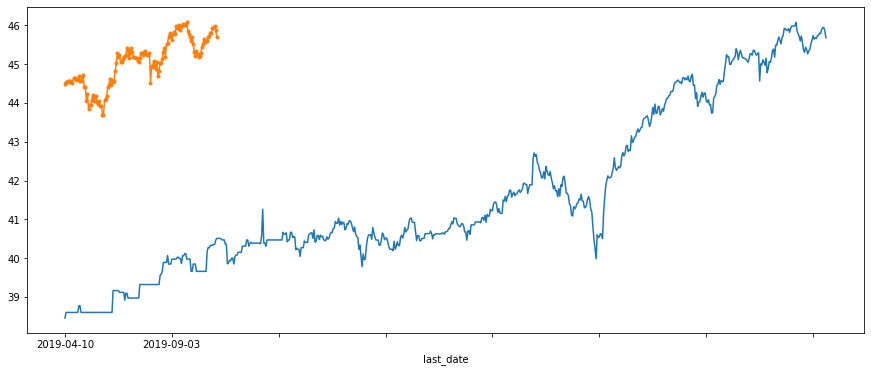

In [28]:
plt.figure(figsize=(15, 6))

y.plot(ax=plt.gca())
y_pred.plot(ax=plt.gca(), legend=None, marker=".")

In [29]:
X_test_selected

,Close__symmetry_looking__r_0.30000000000000004,Open__symmetry_looking__r_0.25,Open__symmetry_looking__r_0.1,Open__has_duplicate_max,Close__symmetry_looking__r_0.25,High__large_standard_deviation__r_0.4,Low__symmetry_looking__r_0.30000000000000004,Low__symmetry_looking__r_0.25,Low__has_duplicate,Low__has_duplicate_min,...,"High__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""var""",Low__partial_autocorrelation__lag_8,"holiday__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.2","holiday__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.4",holiday__mean_abs_change,"Close__fft_coefficient__attr_""angle""__coeff_8",Low__autocorrelation__lag_0,Open__approximate_entropy__m_2__r_0.3,holiday__quantile__q_0.6,Close__mean_second_derivative_central
last_date,,,,,,,,,,,,,,,,,,,,,
2019-04-10,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,-0.541024,-0.567558,0.00,0.00,0.10,124.277799,1.0,0.267818,0.0,0.009195
2019-04-11,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,-0.296359,-0.199343,0.00,0.00,0.10,170.678894,1.0,0.218440,0.0,-0.005732
2019-04-12,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,-0.072752,-0.466256,0.00,0.00,0.10,152.808724,1.0,0.334420,0.0,0.006468
2019-04-15,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,-0.020683,-0.406593,-0.05,-0.05,0.05,161.574626,1.0,0.277248,0.0,0.000989
2019-04-16,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,-0.050274,-0.589035,0.00,0.00,0.00,149.386675,1.0,0.317795,0.0,-0.004195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-25,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,-0.788502,-0.151069,0.00,0.00,0.20,156.921173,1.0,0.320036,0.0,-0.000387
2019-10-28,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,-0.895135,-1.087187,0.00,0.00,0.20,164.707693,1.0,0.231026,0.0,0.005353
2019-10-29,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,-0.737116,0.251485,0.00,0.00,0.20,175.324744,1.0,0.190480,0.0,0.005445


In [30]:
y_pred

last_date
2019-04-10    44.499196
2019-04-11    44.529658
2019-04-12    44.544355
2019-04-15    44.567774
2019-04-16    44.578854
                ...    
2019-10-25    45.923413
2019-10-28    45.966484
2019-10-29    45.989723
2019-10-30    45.892215
2019-10-31    45.710516
Length: 143, dtype: float64

In [31]:
y_test

Date
2019-04-10    44.4837
2019-04-11    44.5318
2019-04-12    44.5423
2019-04-15    44.5799
2019-04-16    44.5887
               ...   
2019-10-25    45.9002
2019-10-28    45.9425
2019-10-29    45.9515
2019-10-30    45.8526
2019-10-31    45.6817
Name: Close, Length: 143, dtype: float64

In [32]:
print(mean_squared_error(y_test.tolist(), y_pred.tolist(), squared=False))

0.054033989954079556
